In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [2]:
from analysis import collection
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle
from analysis import analysis

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

In [3]:
task_name = "center_hold"
with open('olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)

## filter: skip first 100 samples, 50th percentile filter per trial, 1-99.9 percentile global

In [6]:
ROOT_RAWDATA_PATH = Path("/Users/spencer/motor-control/data/rawdata/")
ROOT_METADATA_PATH = Path("/Users/spencer/motor-control/data/metadata/")

def load_raw_trial_stack(subject):
    raw_stack = np.empty(shape=(45, 12, 64, 2000))
    raw_stack[:] = np.nan
    for session_idx, session in enumerate(subject.tasks[task_name].sorted_sessions()[:45]):
        for target_idx in range(1,13):
            for trial in session.sorted_trials():
                if trial.outcome != "No Hold" and trial.target_number == target_idx:
                    e = trial.get_filtered_emg()
                    # trim the beginning of the trial
                    e = e[100:,:]
                    raw_stack[session_idx, target_idx-1, :, :e.shape[0]] = e.T
    return raw_stack

def load_trajectory_stack(subject):
    trajectory_stack = np.empty(shape=(45, 12, 2, 2000))
    trajectory_stack[:] = np.nan
    for session_idx, session in enumerate(subject.tasks[task_name].sorted_sessions()[:45]):
        for target_idx in range(1,13):
            for trial in session.sorted_trials():
                if trial.outcome != "No Hold" and trial.target_number == target_idx:
                    t = trial.get_trajectory()
                    # trim the beginning of the trial
                    t = t[100:,:]
                    trajectory_stack[session_idx, target_idx-1, :, :t.shape[0]] = t.T
    return trajectory_stack

def compute_cutoffs(subject_stack):
    # global cutoffs
    assert subject_stack.shape[2] == 64, subject_stack.shape
    samples = analysis.remove_nan_rows(subject_stack.transpose(0,1,3,2).reshape(-1,64))
    lognorms = np.log(np.linalg.norm(samples,axis=1))
    return (np.percentile(lognorms,1), np.percentile(lognorms,99.9))

def find_cutoff_mask(signal,cutoffs):
    # use this with single trials!
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    assert len(cutoffs) == 2
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mask = (cutoffs[0] < log_norm) * (log_norm < cutoffs[1])
    return np.arange(signal.shape[0])[mask]

def find_within_trial_mask(signal):
    # within trial values -- 30th percentile of log X
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mean_log_norm = np.mean(log_norm)
    std_log_norm = np.std(log_norm)
    # assuming large samples and rv being lognormal, this is roughly the 30th percentile
    mask = log_norm > (mean_log_norm - 0.0*std_log_norm)
    return np.arange(signal.shape[0])[mask]

def find_trial_filter_indices(signal, cutoffs):
    # combine filters
    assert signal.shape[1] == 64, signal.shape
    assert signal.shape[0] > signal.shape[1], signal.shape
    return np.array([i for i in range(signal.shape[0]) if ((i in find_within_trial_mask(signal)) and (i in find_cutoff_mask(signal, cutoffs)))])

# load and filter the data
def filter_subject_trial_stack(subject_stack):
    assert subject_stack.shape[2] == 64
    assert len(subject_stack.shape) == 4
    # session, trial, channel, time
    stack = np.zeros_like(subject_stack)
    stack[:] = np.nan
    cutoffs = compute_cutoffs(subject_stack)
    for session_idx, session_trials in enumerate(subject_stack):
        for trial_idx, e in enumerate(session_trials):
            assert e.shape[0] == 64, e.shape
            assert e.shape[1] > e.shape[0], e.shape
            e_without_nans = analysis.remove_nan_rows(e.T)
            if e_without_nans.shape[0] < e_without_nans.shape[1]:
                print(f"Empty trial: {session_idx,trial_idx}")
            else:
                indices = find_trial_filter_indices(e_without_nans,cutoffs)
                e = e[:,indices]
                # stuff this into stack array
                stack[session_idx, trial_idx, :, :e.shape[1]] = e
    return stack


## build data brick
### NB this is SESSION, TARGET, CHANNEL, TIME !!

In [6]:
# test stepping through raw data
filtered_stacks = []
raw_stacks = []
trajectory_stacks = []
for subject_idx, subject in enumerate(subjects):
    raw_stack = load_raw_trial_stack(subject)
    trajectory_stack = load_trajectory_stack(subject)
    filtered_stack = filter_subject_trial_stack(raw_stack)
    filtered_stacks += [filtered_stack]
    raw_stacks += [raw_stack]
    trajectory_stacks += [trajectory_stack]
filtered_stacks = np.array(filtered_stacks)
raw_stacks = np.array(raw_stacks)
trajectory_stacks = np.array(trajectory_stacks)
print(raw_stacks.shape, filtered_stacks.shape, trajectory_stacks.shape)

Empty trial: (44, 3)
Empty trial: (44, 6)
Empty trial: (44, 8)
Empty trial: (0, 7)
Empty trial: (0, 10)
Empty trial: (31, 2)
Empty trial: (31, 5)
Empty trial: (31, 9)
Empty trial: (21, 0)
Empty trial: (21, 1)
Empty trial: (21, 2)
Empty trial: (21, 3)
Empty trial: (21, 4)
Empty trial: (21, 5)
Empty trial: (21, 6)
Empty trial: (21, 7)
Empty trial: (21, 8)
Empty trial: (21, 9)
Empty trial: (21, 10)
Empty trial: (21, 11)
Empty trial: (14, 3)
Empty trial: (14, 5)
Empty trial: (18, 2)
Empty trial: (0, 2)
Empty trial: (0, 3)
Empty trial: (0, 6)
Empty trial: (0, 7)
Empty trial: (0, 8)
Empty trial: (0, 9)
Empty trial: (0, 11)
Empty trial: (44, 5)
Empty trial: (30, 3)
Empty trial: (30, 7)
Empty trial: (34, 10)
Empty trial: (11, 8)
Empty trial: (7, 1)
Empty trial: (7, 2)
Empty trial: (7, 5)
Empty trial: (7, 6)
Empty trial: (7, 9)
Empty trial: (7, 10)
Empty trial: (7, 11)
Empty trial: (1, 1)
Empty trial: (3, 0)
Empty trial: (17, 10)
Empty trial: (18, 10)
(46, 45, 12, 64, 2000) (46, 45, 12, 64, 200

## save / load

In [7]:
np.save("subject_raw_trial_stacks.npy", raw_stacks)
np.save("subject_trial_stacks.npy", filtered_stacks)
np.save("subject_trajectory_stacks.npy", trajectory_stacks)

In [4]:
subject_raw_trial_stacks = np.load("subject_raw_trial_stacks.npy")
print(subject_raw_trial_stacks.shape)

subject_trial_stacks = np.load("subject_trial_stacks.npy")
print(subject_trial_stacks.shape)

subject_trajectory_stacks = np.load("subject_trajectory_stacks.npy")
print(subject_trajectory_stacks.shape)

(46, 45, 12, 64, 2000)
(46, 45, 12, 64, 2000)
(46, 45, 12, 2, 2000)


## inspect EMG

In [7]:
subject_idx = 0
subject = subjects[subject_idx]
session_idx = 34
target_idx = 1
cutoffs = compute_cutoffs(subject_raw_trial_stacks[subject_idx])
e = analysis.remove_nan_rows(subject_raw_trial_stacks[subject_idx,session_idx,target_idx,:,:].T)
indices = find_trial_filter_indices(e,cutoffs)

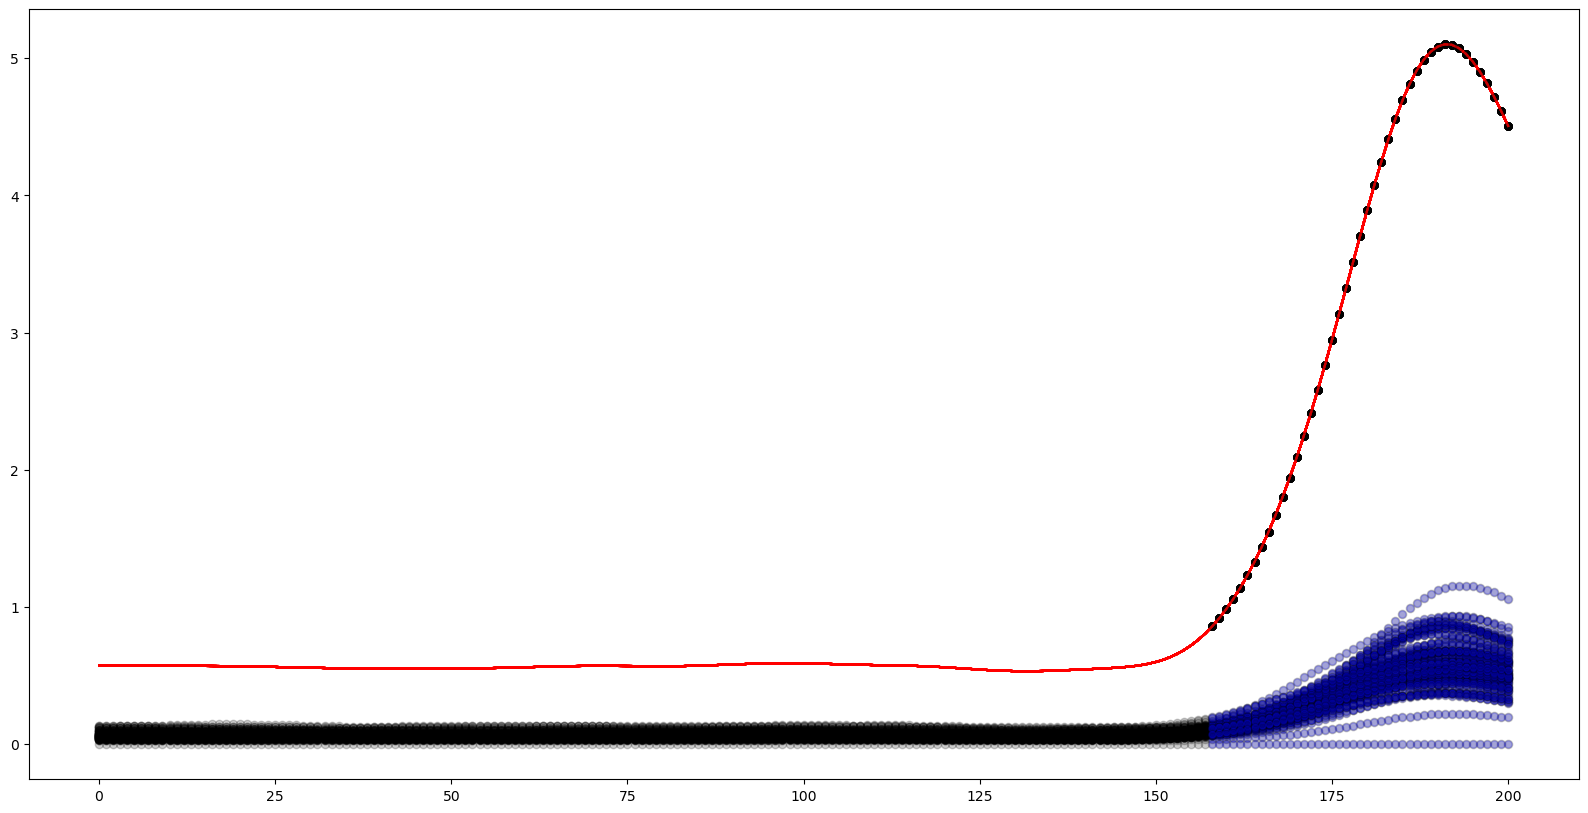

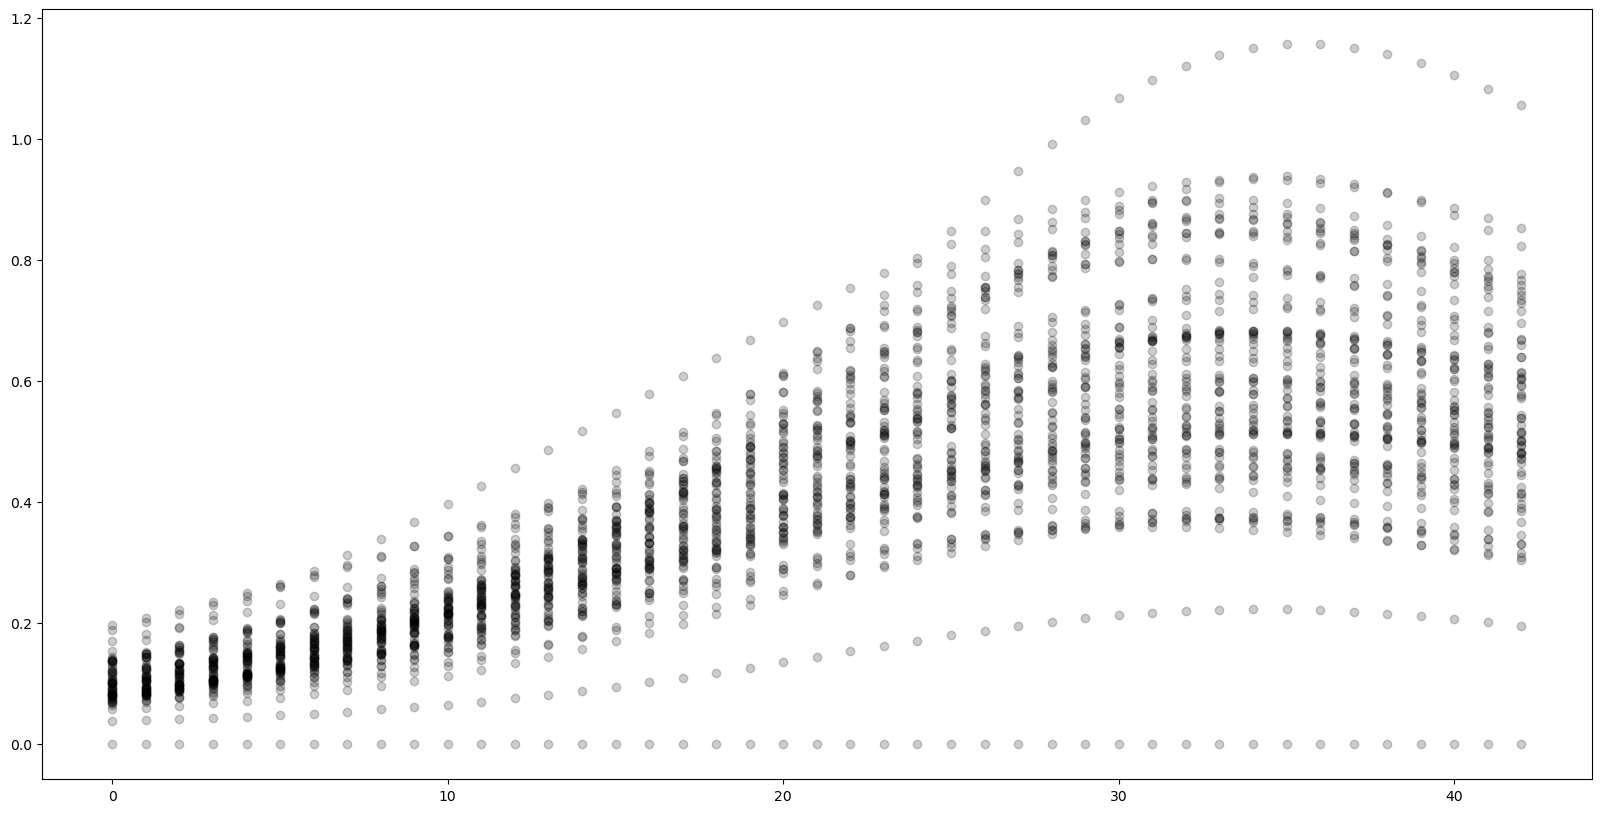

: 

In [8]:
plt.figure(figsize=(20,10))
for ch in range(0,64):
    plt.plot(e[:,ch],'ko',alpha=0.2)
    plt.plot(indices, e[indices,ch],'bo',alpha=0.2,markersize=5)
    plt.plot(np.linalg.norm(e,axis=1),"r",)
    plt.plot(indices,np.linalg.norm(e,axis=1)[indices],"ko",alpha=0.2,markersize=5)
plt.figure(figsize=(20,10))
for ch in range(0,64):
    plt.plot(subject_trial_stacks[subject_idx,session_idx,target_idx,ch],'ko',alpha=0.2)

## inspect trajectory

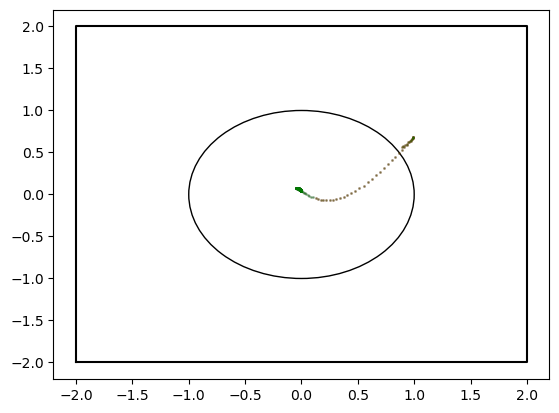

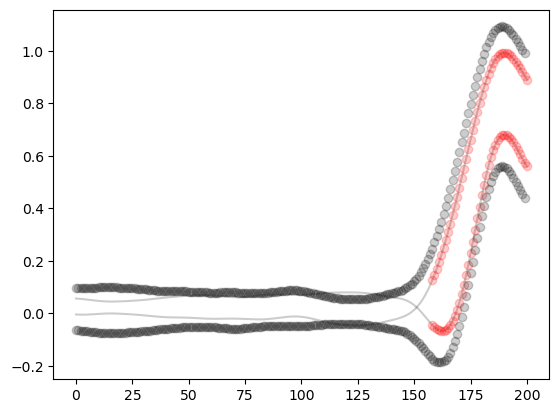

In [13]:
d = subject.decoder[-2:,:]
t = d @ e.T
tr = subject_trajectory_stacks[subject_idx,session_idx,target_idx]

plt.figure()
plt.plot(t[0],t[1],"ko",alpha=0.2,markersize=1)
plt.plot(t[0,indices],t[1,indices],"ro",alpha=0.2,markersize=1)
l = 2
plt.plot([-l,-l,l,l,-l],[-l,l,l,-l,-l],'k')
c = plt.Circle([0,0],1,color="k",fill=None)
plt.gca().add_patch(c)
plt.plot(t[0],t[1],'go',alpha=0.2,markersize=1)

plt.figure()
plt.plot(t[0],'k',alpha=0.2)
plt.plot(t[1],'k',alpha=0.2)
plt.plot(indices,t[0,indices],'ro',alpha=0.2)
plt.plot(indices,t[1,indices],'ro',alpha=0.2)
plt.plot(tr[0],'ko',alpha=0.2)
plt.plot(tr[1],'ko',alpha=0.2)

## inspect histograms

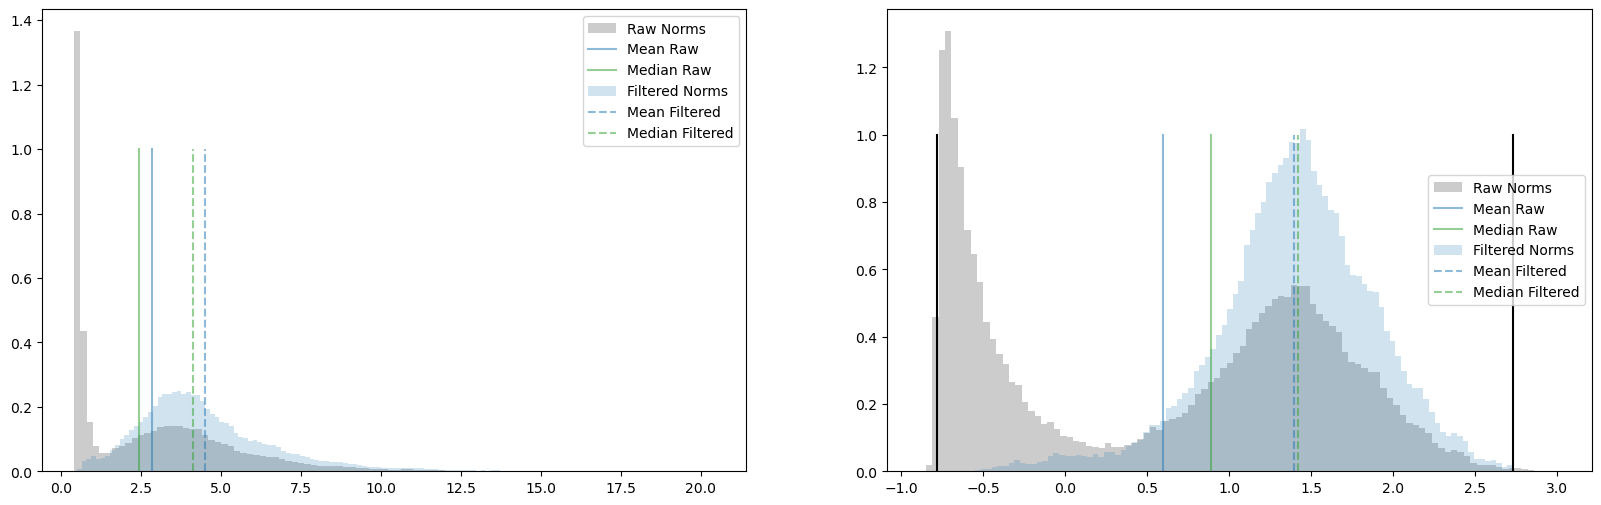

In [49]:
def plot_stats(signal, ax, linestyle="-", label=""):
    mean = np.mean(signal)
    ax.plot([mean, mean], [0,1],'tab:blue',linestyle=linestyle,label="Mean" + label,alpha=0.5)
    median = np.median(signal)
    ax.plot([median, median], [0,1],'tab:green',linestyle=linestyle,label="Median" + label,alpha=0.5)


for subject_idx in range(len(subjects)):
    fig, axes = plt.subplots(1,2,figsize=(20,6))

    raw_stack = raw_stacks[subject_idx]
    filtered_stack = filtered_stacks[subject_idx]

    raw_samples = analysis.remove_nan_rows(raw_stack.transpose(0,1,3,2).reshape(-1,64))
    filtered_samples = analysis.remove_nan_rows(filtered_stack.transpose(0,1,3,2).reshape(-1,64))

    raw_norms = np.linalg.norm(raw_samples,axis=1)
    filtered_norms = np.linalg.norm(filtered_samples,axis=1)
    raw_log_norms = np.log(np.linalg.norm(raw_samples,axis=1))
    filtered_log_norms = np.log(np.linalg.norm(filtered_samples,axis=1))

    # sample norms
    axes[0].hist(raw_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
    plot_stats(raw_norms, axes[0],label=" Raw")
    # filtered norms
    axes[0].hist(filtered_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
    plot_stats(filtered_norms,axes[0],linestyle="--",label=" Filtered")
    axes[0].legend()

    # sample norms
    axes[1].hist(raw_log_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
    plot_stats(raw_log_norms, axes[1],label=" Raw")
    # filtered norms
    axes[1].hist(filtered_log_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
    plot_stats(filtered_log_norms,axes[1],linestyle="--",label=" Filtered")

    axes[1].plot([cutoffs[0],cutoffs[0]],[0,1],"k")
    axes[1].plot([cutoffs[1],cutoffs[1]],[0,1],"k")

    axes[1].legend()
